In [1]:
# !pip3 install boto3

https://docs.aws.amazon.com/rekognition/latest/dg/images.html

In [2]:
import base64
import boto3
import json
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from typing import Tuple

from PIL import Image, ImageDraw, UnidentifiedImageError

RED = (255, 0, 0)  # For objects within the ROI
GREEN = (0, 255, 0)  # For ROI box
YELLOW = (255, 255, 0)  # For objects outside the ROI

def draw_box(
    draw: ImageDraw,
    box: Tuple[float, float, float, float],
    img_width: int,
    img_height: int,
    text: str = "",
    color: Tuple[int, int, int] = (255, 255, 0),
) -> None:
    """
    Draw a bounding box on and image.

    The bounding box is defined by the tuple (y_min, x_min, y_max, x_max)
    where the coordinates are floats in the range [0.0, 1.0] and
    relative to the width and height of the image.

    For example, if an image is 100 x 200 pixels (height x width) and the bounding
    box is `(0.1, 0.2, 0.5, 0.9)`, the upper-left and bottom-right coordinates of
    the bounding box will be `(40, 10)` to `(180, 50)` (in (x,y) coordinates).
    """

    line_width = 3
    font_height = 8
    y_min, x_min, y_max, x_max = box
    (left, right, top, bottom) = (
        x_min * img_width,
        x_max * img_width,
        y_min * img_height,
        y_max * img_height,
    )
    draw.line(
        [(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
        width=line_width,
        fill=color,
    )
    if text:
        draw.text(
            (left + line_width, abs(top - line_width - font_height)), text, fill=color
        )

In [3]:
ls *.jpg

annotated.jpg  people_car.jpg  smart_meter.jpg


In [4]:
FIG_SIZE = (20, 12)
image_file='people_car.jpg'

REGION='us-west-2'

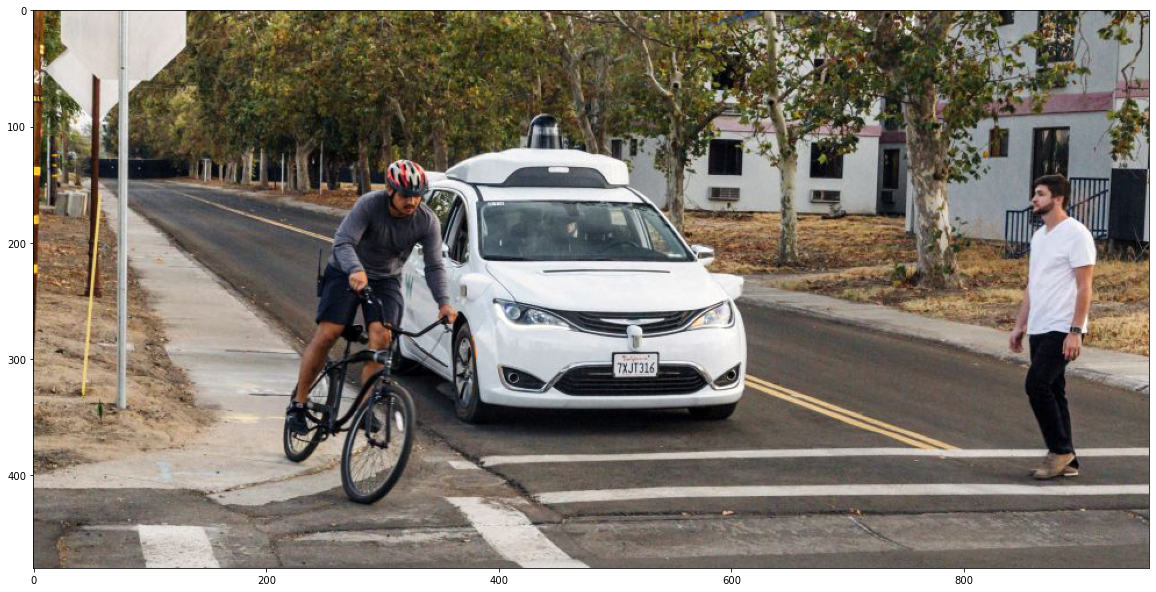

In [5]:
img = plt.imread(image_file)
fig, ax = plt.subplots(figsize=FIG_SIZE)
ax.imshow(img);

In [6]:
client=boto3.client('rekognition', region_name=REGION)

## Object and scene detection
https://docs.aws.amazon.com/rekognition/latest/dg/labels.html

In [7]:
%%time
with open(image_file, 'rb') as image:
    try:
        response = client.detect_labels(Image={'Bytes': image.read()})
    except Exception as exc:
        print(exc)

CPU times: user 21.9 ms, sys: 11.1 ms, total: 33 ms
Wall time: 1.92 s


In [8]:
def get_objects(response: str) -> dict:
    """Parse the data, returning detected objects only."""
    objects = []
    labels = []
    decimal_places = 3

    for label in response["Labels"]:
        if len(label["Instances"]) > 0:
            for instance in label["Instances"]:
                # Extract and format instance data
                box = instance["BoundingBox"]
                # Get bounding box
                x_min, y_min, width, height = (
                    box["Left"],
                    box["Top"],
                    box["Width"],
                    box["Height"],
                )
                x_max, y_max = x_min + width, y_min + height

                bounding_box = {
                    "x_min": round(x_min, decimal_places),
                    "y_min": round(y_min, decimal_places),
                    "x_max": round(x_max, decimal_places),
                    "y_max": round(y_max, decimal_places),
                    "width": round(box["Width"], decimal_places),
                    "height": round(box["Height"], decimal_places),
                }

                # Get box area (% of frame)
                box_area = width * height * 100

                # Get box centroid
                centroid_x, centroid_y = (x_min + width / 2), (y_min + height / 2)
                centroid = {
                    "x": round(centroid_x, decimal_places),
                    "y": round(centroid_y, decimal_places),
                }

                objects.append(
                    {
                        "name": label["Name"].lower(),
                        "confidence": round(instance["Confidence"], decimal_places),
                        "bounding_box": bounding_box,
                        "box_area": round(box_area, decimal_places),
                        "centroid": centroid,
                    }
                )
        else:
            label_info = {
                "name": label["Name"].lower(),
                "confidence": round(label["Confidence"], decimal_places),
            }
            labels.append(label_info)
    return objects, labels

In [9]:
objects, labels = get_objects(response)

In [10]:
labels

[{'name': 'human', 'confidence': 99.853},
 {'name': 'bike', 'confidence': 99.85},
 {'name': 'vehicle', 'confidence': 99.85},
 {'name': 'transportation', 'confidence': 99.85},
 {'name': 'machine', 'confidence': 99.477},
 {'name': 'automobile', 'confidence': 99.364},
 {'name': 'clothing', 'confidence': 97.616},
 {'name': 'footwear', 'confidence': 97.616},
 {'name': 'apparel', 'confidence': 97.616},
 {'name': 'cyclist', 'confidence': 91.207},
 {'name': 'sport', 'confidence': 91.207},
 {'name': 'sports', 'confidence': 91.207},
 {'name': 'road', 'confidence': 71.861},
 {'name': 'tarmac', 'confidence': 65.625},
 {'name': 'asphalt', 'confidence': 65.625},
 {'name': 'people', 'confidence': 58.185}]

In [11]:
img = Image.open(image_file)
draw = ImageDraw.Draw(img)

In [12]:
for obj in objects:
    name = obj["name"]
    confidence = obj["confidence"]
    box = obj["bounding_box"]
    centroid = obj["centroid"]
    box_label = f"{name}: {confidence:.1f}%"
    
    draw_box(
    draw,
    (box["y_min"], box["x_min"], box["y_max"], box["x_max"]),
    img.width,
    img.height,
    text=box_label,
    color=RED,
    )

    # draw bullseye
    draw.text(
        (centroid["x"] * img.width, centroid["y"] * img.height),
        text="X",
        fill=RED,
    )

In [13]:
img.save("annotated.jpg", "JPEG")

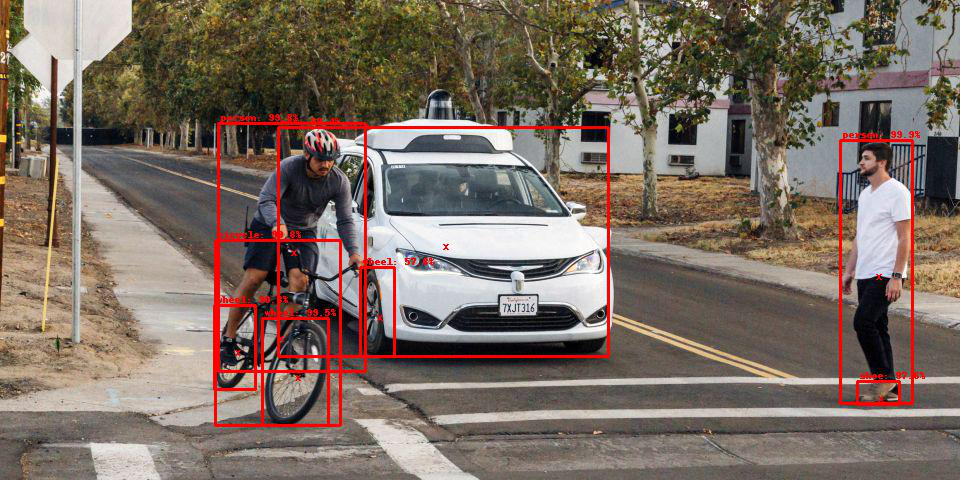

In [14]:
Image.open("annotated.jpg")

## Face detection
https://docs.aws.amazon.com/rekognition/latest/dg/faces-detect-images.html

In [15]:
%%time
with open(image_file, 'rb') as image:
    try:
        response = client.detect_faces(Image={'Bytes': image.read()})
    except Exception as exc:
        print(exc)

CPU times: user 9.62 ms, sys: 12 µs, total: 9.64 ms
Wall time: 1.19 s


In [16]:
len(response['FaceDetails'])

2

In [17]:
response['FaceDetails'][0]

{'BoundingBox': {'Width': 0.02692251279950142,
  'Height': 0.05310859531164169,
  'Left': 0.32145464420318604,
  'Top': 0.31489041447639465},
 'Landmarks': [{'Type': 'eyeLeft',
   'X': 0.3345753252506256,
   'Y': 0.3332329988479614},
  {'Type': 'eyeRight', 'X': 0.3449747860431671, 'Y': 0.33522462844848633},
  {'Type': 'mouthLeft', 'X': 0.33334171772003174, 'Y': 0.35505616664886475},
  {'Type': 'mouthRight', 'X': 0.3421221077442169, 'Y': 0.3566909730434418},
  {'Type': 'nose', 'X': 0.3405616879463196, 'Y': 0.34920957684516907}],
 'Pose': {'Roll': -2.723209857940674,
  'Yaw': 20.657684326171875,
  'Pitch': -32.434539794921875},
 'Quality': {'Brightness': 39.38178634643555, 'Sharpness': 38.89601135253906},
 'Confidence': 99.99626922607422}